In [2]:
## Transformations

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [4]:
## dataset download, split train/test

train = datasets.MNIST("./data", train=True, download=True, transform=train_transforms)
test = datasets.MNIST("./data", train=False, download=True, transform=test_transforms)

In [5]:
## Dataloader args

SEED = 1

torch.manual_seed(SEED)

cuda = torch.cuda.is_available()
print(f"CUDA Available: ", cuda)

if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available:  True


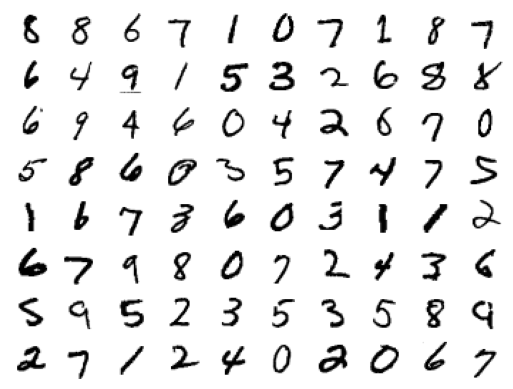

In [9]:
## Load data

dataiter = iter(train_loader)
images, labels = next(dataiter)

## Visualize data
import matplotlib.pyplot as plt

fig = plt.figure()
num_images = 80
for idx in range(1, num_images+1):
    plt.subplot(8, 10, idx)
    plt.axis('off')
    plt.imshow(images[idx].numpy().squeeze(), cmap='gray_r')

In [13]:
## Neural Network

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            nn.ReLU()
        ) # n_out = (28-3) + 1 = 26 ; Jout = Jin*S = 1*1 = 1 ; Rf_out = Rin + (K-1)*Jin = 1 + (3-1)*1 = 3

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU()
        ) # n_out = (26-3) + 1 = 24; Jout = 1 ; Rf_out = 3 + (3-1)*1 = 5

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU()
        ) # n_out = 24, Jout = 1; Rf_out = 5 + (3-1)*1 = 7

        self.max_pool1 = nn.MaxPool2d((2,2)) 
        # n_out = (24-2)/2 + 1 = 12, Jout = 2*1 = 2, Rf_out = 7 + (2-1)*1 = 9

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=0),
            nn.ReLU()) # n_out = (12-3) + 1 = 10; Jout = 2; Rf_out = 9 + (3-1)*2 = 13

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=0),
            nn.ReLU()) # n_out = (10-3) + 1 = 8; Jout = 2; Rf_out = 13 + (3-1)*2 = 17

        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=0),
            nn.ReLU()) # n_out = (8-3) + 1 = 6; Jout = 2; Rf_out = 17 + (3-1)*2 = 21

        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=0),
            nn.ReLU()) # n_out = (6-3) + 1 = 4; Jout = 2; Rf_out = 21 + (3-1)*2 = 25

        self.conv8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(4, 4), padding=0))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.max_pool1(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [14]:
!pip install torchsummary

In [15]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("> Device alloted: ", device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

> Device alloted:  cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,496
              ReLU-4           [-1, 64, 24, 24]               0
            Conv2d-5          [-1, 128, 24, 24]          73,856
              ReLU-6          [-1, 128, 24, 24]               0
         MaxPool2d-7          [-1, 128, 12, 12]               0
            Conv2d-8           [-1, 64, 10, 10]          73,792
              ReLU-9           [-1, 64, 10, 10]               0
           Conv2d-10             [-1, 64, 8, 8]          36,928
             ReLU-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 32, 6, 6]          18,464
             ReLU-13             [-1, 32, 6, 6]               0
           Conv

In [16]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [17]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.1647144854068756 Batch_id=468 Accuracy=70.53: 100%|██████████| 469/469 [00:08<00:00, 53.25it/s]  



Test set: Average loss: 0.1224, Accuracy: 9617/10000 (96.17%)

EPOCH: 1


Loss=0.05799933895468712 Batch_id=468 Accuracy=96.82: 100%|██████████| 469/469 [00:07<00:00, 59.07it/s] 



Test set: Average loss: 0.0728, Accuracy: 9778/10000 (97.78%)

EPOCH: 2


Loss=0.1345030963420868 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:07<00:00, 58.72it/s]   



Test set: Average loss: 0.0505, Accuracy: 9837/10000 (98.37%)

EPOCH: 3


Loss=0.008382366970181465 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:08<00:00, 56.44it/s] 



Test set: Average loss: 0.0388, Accuracy: 9877/10000 (98.77%)

EPOCH: 4


Loss=0.08616864681243896 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:08<00:00, 58.60it/s]  



Test set: Average loss: 0.0395, Accuracy: 9871/10000 (98.71%)

EPOCH: 5


Loss=0.07356295734643936 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:08<00:00, 58.47it/s]  



Test set: Average loss: 0.0477, Accuracy: 9843/10000 (98.43%)

EPOCH: 6


Loss=0.02816026471555233 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:08<00:00, 58.12it/s]  



Test set: Average loss: 0.0375, Accuracy: 9885/10000 (98.85%)

EPOCH: 7


Loss=0.010484968312084675 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:08<00:00, 55.88it/s] 



Test set: Average loss: 0.0326, Accuracy: 9902/10000 (99.02%)

EPOCH: 8


Loss=0.00939058419317007 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:08<00:00, 58.05it/s]  



Test set: Average loss: 0.0333, Accuracy: 9901/10000 (99.01%)

EPOCH: 9


Loss=0.0016046572709456086 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:08<00:00, 58.04it/s]



Test set: Average loss: 0.0337, Accuracy: 9899/10000 (98.99%)

EPOCH: 10


Loss=0.004003499168902636 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:08<00:00, 55.75it/s] 



Test set: Average loss: 0.0384, Accuracy: 9889/10000 (98.89%)

EPOCH: 11


Loss=0.0016122646629810333 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:08<00:00, 58.35it/s]



Test set: Average loss: 0.0325, Accuracy: 9910/10000 (99.10%)

EPOCH: 12


Loss=0.006546309683471918 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:08<00:00, 57.23it/s]  



Test set: Average loss: 0.0341, Accuracy: 9890/10000 (98.90%)

EPOCH: 13


Loss=0.054106488823890686 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:08<00:00, 57.58it/s]  



Test set: Average loss: 0.0288, Accuracy: 9918/10000 (99.18%)

EPOCH: 14


Loss=0.006212655920535326 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:08<00:00, 55.93it/s]  



Test set: Average loss: 0.0307, Accuracy: 9914/10000 (99.14%)

EPOCH: 15


Loss=0.004026658367365599 Batch_id=468 Accuracy=99.65: 100%|██████████| 469/469 [00:08<00:00, 57.54it/s]  



Test set: Average loss: 0.0393, Accuracy: 9875/10000 (98.75%)

EPOCH: 16


Loss=0.00020542614220175892 Batch_id=468 Accuracy=99.67: 100%|██████████| 469/469 [00:08<00:00, 57.58it/s]



Test set: Average loss: 0.0374, Accuracy: 9902/10000 (99.02%)

EPOCH: 17


Loss=0.005628372076898813 Batch_id=468 Accuracy=99.67: 100%|██████████| 469/469 [00:08<00:00, 55.71it/s]  



Test set: Average loss: 0.0347, Accuracy: 9914/10000 (99.14%)

EPOCH: 18


Loss=0.00016840540047269315 Batch_id=468 Accuracy=99.70: 100%|██████████| 469/469 [00:08<00:00, 57.37it/s]



Test set: Average loss: 0.0348, Accuracy: 9908/10000 (99.08%)

EPOCH: 19


Loss=0.00030244237859733403 Batch_id=468 Accuracy=99.72: 100%|██████████| 469/469 [00:08<00:00, 57.14it/s]



Test set: Average loss: 0.0357, Accuracy: 9908/10000 (99.08%)



Text(0.5, 1.0, 'Test Accuracy')

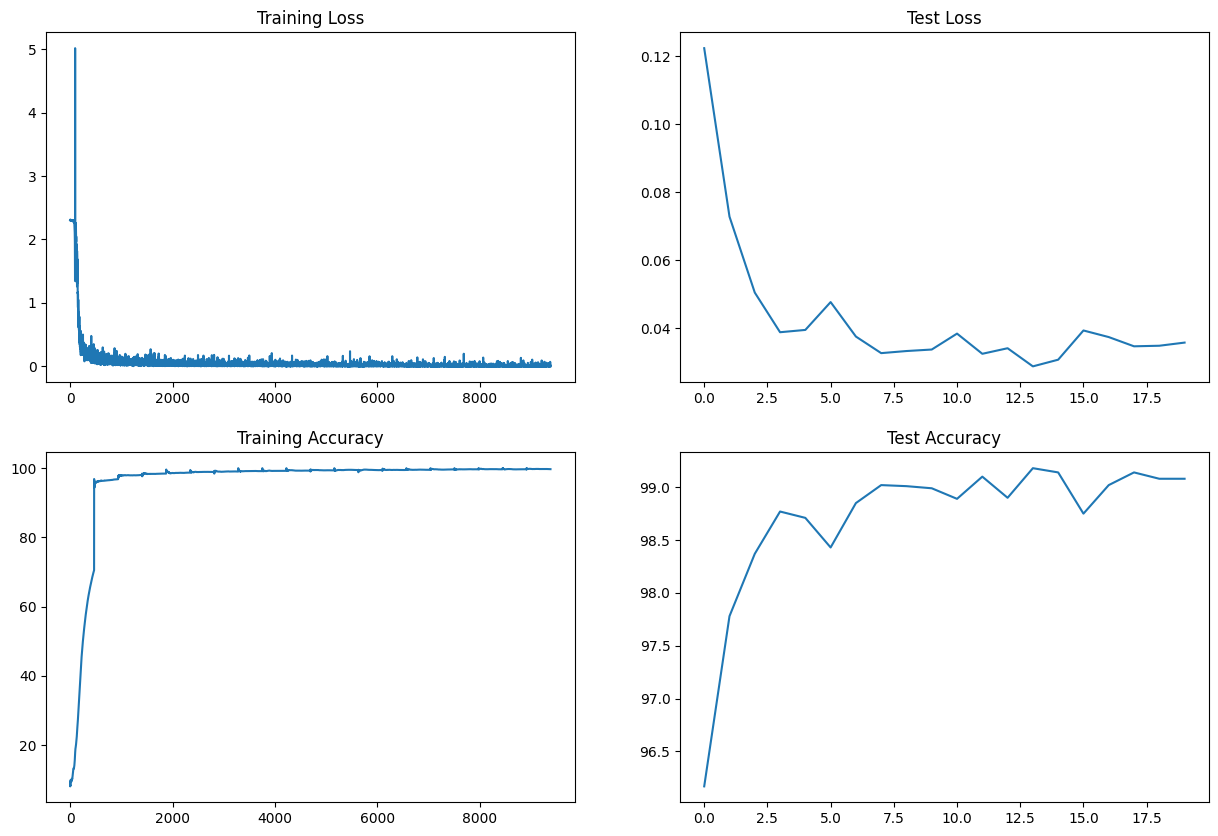

In [18]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

**Target**:
----------

1. Setup a little bit of heavy parameterized.

2. Basic necessary transforms of ToTensor(), Normalize

3. Stored via Dataloader

4. Huge Parameters Neural Network

5. Basic Training & Testing Loops

6. Train for 20 Epochs & Visualize logs


**Result**:
---------
A. Parameters: 2.3M (236,234)

B. Best Training Accuracy: 99.72 (20th EPOCH)

C. Best Test Accuracy: 99.18 (14th EPOCH)


**Analysis**:
------------

A. A little bit of Heavy Model for such a problem (MNIST, as its image size is of only 28*28, we have to reduce network architectures)

B. Can oversee the overfitting in large difference.

C. The test loss & test accuracy seems to be fluctuate a lot in the last few epochs, also the train loss & train accuracy made a steady straight line with little bit of backward & forward in performance. As from the chart, the accuracy seems to be increased and again a bit of decrement. 